In [24]:
import pandas as pd
import numpy as np
import re
import sys
import zipfile
import time
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pixel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
# Path to the downloaded ZIP file
zip_path = 'Amazon-Products.zip'

# Extract and read the CSV file
with zipfile.ZipFile(zip_path, 'r') as z:
    with z.open('Amazon-Products.csv') as f:
        df = pd.read_csv(f)

# Display the first few rows of the DataFrame
print(df.head())

   Unnamed: 0                                               name  \
0           0  Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...   
1           1  LG 1.5 Ton 5 Star AI DUAL Inverter Split AC (C...   
2           2  LG 1 Ton 4 Star Ai Dual Inverter Split Ac (Cop...   
3           3  LG 1.5 Ton 3 Star AI DUAL Inverter Split AC (C...   
4           4  Carrier 1.5 Ton 3 Star Inverter Split AC (Copp...   

  main_category      sub_category  \
0    appliances  Air Conditioners   
1    appliances  Air Conditioners   
2    appliances  Air Conditioners   
3    appliances  Air Conditioners   
4    appliances  Air Conditioners   

                                               image  \
0  https://m.media-amazon.com/images/I/31UISB90sY...   
1  https://m.media-amazon.com/images/I/51JFb7FctD...   
2  https://m.media-amazon.com/images/I/51JFb7FctD...   
3  https://m.media-amazon.com/images/I/51JFb7FctD...   
4  https://m.media-amazon.com/images/I/41lrtqXPiW...   

                               

In [26]:
# Knowing the number of rows and columns
df.shape

(551585, 10)

In [27]:
# Checking the missing values
df.isnull().sum()

Unnamed: 0             0
name                   0
main_category          0
sub_category           0
image                  0
link                   0
ratings           175794
no_of_ratings     175794
discount_price     61163
actual_price       17813
dtype: int64

In [28]:
# Droping the columns with 70% or more missing data
perc = 70.0 
min_count =  int(((100 - perc)/100) * df.shape[1] + 1)
mod_df = df.dropna(axis = 1, thresh = min_count)

In [29]:
# Removing the ₹ sign
mod_df["discount_price"] = mod_df["discount_price"].str.split(" ", expand = True).get(0).str.split("₹", expand = True).get(1)
mod_df["actual_price"] = mod_df["actual_price"].str.split(" ", expand = True).get(0).str.split("₹", expand = True).get(1)
# Change commas to dots and change the type to float
mod_df['discount_price'] = mod_df["discount_price"].str.replace(',', '').astype(float)
mod_df["actual_price"] = mod_df["actual_price"].str.replace(',', '').astype(float)

In [30]:
# Modify ratings values
mod_df['ratings'].unique()

array(['4.2', '4.0', '4.1', '4.3', '3.9', '3.8', '3.5', nan, '4.6', '3.3',
       '3.4', '3.7', '2.9', '5.0', '4.4', '3.6', '2.7', '4.5', '3.0',
       '3.1', '3.2', '4.8', '4.7', '2.5', '1.0', '2.6', '2.8', '2.3',
       '1.7', 'Get', '1.8', '2.4', '4.9', '2.2', '1.6', '1.9', '2.0',
       '1.4', '2.1', 'FREE', '1.2', '1.3', '1.5', '₹68.99', '₹65', '1.1',
       '₹70', '₹100', '₹99', '₹2.99'], dtype=object)

In [31]:
# Extract the digits and change the type to float
mod_df['ratings'] = mod_df['ratings'].replace(['Get','FREE','₹68.99', '₹65','₹70', '₹100', '₹99', '₹2.99'], '0.0')
mod_df['ratings'] = mod_df["ratings"].astype(float)
mod_df['ratings'].unique()

array([4.2, 4. , 4.1, 4.3, 3.9, 3.8, 3.5, nan, 4.6, 3.3, 3.4, 3.7, 2.9,
       5. , 4.4, 3.6, 2.7, 4.5, 3. , 3.1, 3.2, 4.8, 4.7, 2.5, 1. , 2.6,
       2.8, 2.3, 1.7, 0. , 1.8, 2.4, 4.9, 2.2, 1.6, 1.9, 2. , 1.4, 2.1,
       1.2, 1.3, 1.5, 1.1])

In [32]:
# Add column 'correct_no_of_ratings' which value is 'True' if 'no_of_ratings' begins from digit 
mod_df['no_of_ratings'] = mod_df['no_of_ratings'].astype(str)
mod_df['correct_no_of_ratings'] = pd.Series([mod_df['no_of_ratings'][x][0].isdigit() for x in range(len(mod_df['no_of_ratings']))])
# Drop columns with incorrect 'no_of_ratings'
mod_df = mod_df[mod_df['correct_no_of_ratings'] == True]
mod_df['correct_no_of_ratings'].value_counts()

correct_no_of_ratings
True    369558
Name: count, dtype: int64

In [33]:
# Find the minimum and maximum ratings
print('Minimum rating is: %d' %(mod_df['ratings'].min()))
print('Maximum rating is: %d' %(mod_df['ratings'].max()))

Minimum rating is: 1
Maximum rating is: 5


In [34]:
# Change the type to float
mod_df["no_of_ratings"] = mod_df["no_of_ratings"].str.replace(',', '').astype(float)

In [35]:
# Dataframe after first phase of cleaning
mod_df.head()

,Unnamed: 0,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price,correct_no_of_ratings
0,0,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/31UISB90sY...,https://www.amazon.in/Lloyd-Inverter-Convertib...,4.2,2255.0,32999.0,58990.0,True
1,1,LG 1.5 Ton 5 Star AI DUAL Inverter Split AC (C...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Convertible-Anti-Viru...,4.2,2948.0,46490.0,75990.0,True
2,2,LG 1 Ton 4 Star Ai Dual Inverter Split Ac (Cop...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Inverter-Convertible-...,4.2,1206.0,34490.0,61990.0,True
3,3,LG 1.5 Ton 3 Star AI DUAL Inverter Split AC (C...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Convertible-Anti-Viru...,4.0,69.0,37990.0,68990.0,True
4,4,Carrier 1.5 Ton 3 Star Inverter Split AC (Copp...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/41lrtqXPiW...,https://www.amazon.in/Carrier-Inverter-Split-C...,4.1,630.0,34490.0,67790.0,True


In [36]:
mod_df['discount_price'] = mod_df['discount_price'].fillna(mod_df['actual_price'])  # Fill missing discount

In [37]:
# Since our further analysis is based on the price column so let us drop it.
df = mod_df.dropna(subset=['actual_price','discount_price'])
df.head()

,Unnamed: 0,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price,correct_no_of_ratings
0,0,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/31UISB90sY...,https://www.amazon.in/Lloyd-Inverter-Convertib...,4.2,2255.0,32999.0,58990.0,True
1,1,LG 1.5 Ton 5 Star AI DUAL Inverter Split AC (C...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Convertible-Anti-Viru...,4.2,2948.0,46490.0,75990.0,True
2,2,LG 1 Ton 4 Star Ai Dual Inverter Split Ac (Cop...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Inverter-Convertible-...,4.2,1206.0,34490.0,61990.0,True
3,3,LG 1.5 Ton 3 Star AI DUAL Inverter Split AC (C...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Convertible-Anti-Viru...,4.0,69.0,37990.0,68990.0,True
4,4,Carrier 1.5 Ton 3 Star Inverter Split AC (Copp...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/41lrtqXPiW...,https://www.amazon.in/Carrier-Inverter-Split-C...,4.1,630.0,34490.0,67790.0,True


In [38]:
Brands=['Puma',
 'Nike',
 'Van Heusen',
 'Adidas',
 'U.S POLO ASSN',
 'Amazon Basics',
 'Amazon Brand',
 'Campus',
 'Tommy Hilfiger'
 ]

In [39]:
# Create a regex pattern to match any of the brands
pattern = '|'.join(Brands)

# Extract the manufacturer by finding the brand name in the 'name' column
df['manufacturer'] = df['name'].str.extract(f'({pattern})', expand=False)

# Filter the DataFrame to keep only rows where a brand was found
df = df.dropna(subset=['manufacturer'])

# Remove the brand name from the 'name' column
df['name'] = df.apply(lambda row: row['name'].replace(row['manufacturer'], '').strip(), axis=1)

# Get the list of columns
cols = df.columns.tolist()
cols

C:\Users\pixel\AppData\Local\Temp\ipykernel_23376\1091700798.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['manufacturer'] = df['name'].str.extract(f'({pattern})', expand=False)


['Unnamed: 0',
 'name',
 'main_category',
 'sub_category',
 'image',
 'link',
 'ratings',
 'no_of_ratings',
 'discount_price',
 'actual_price',
 'correct_no_of_ratings',
 'manufacturer']

In [40]:
cols = ['name',
 'manufacturer',
 'main_category',
 'sub_category',
 'ratings',
 'no_of_ratings',
 'discount_price',
 'actual_price']

In [41]:
df = df[cols]
df.head()

,name,manufacturer,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price
65,"1 Ton, 5 Star, Wi-Fi Enabled Smart(Alexa/Googl...",Amazon Basics,appliances,Air Conditioners,3.6,88.0,28990.0,49089.0
83,"1.5 Ton, 5 Star, Wi-Fi Enabled Smart(Alexa/Goo...",Amazon Basics,appliances,Air Conditioners,3.4,39.0,34990.0,56179.0
112,"1 Ton 4 Star Fixed Speed Window AC (Copper, Tu...",Amazon Basics,appliances,Air Conditioners,3.5,14.0,25490.0,33990.0
1057,300 W Hand Blender with Stainless Steel Stem f...,Amazon Basics,appliances,All Appliances,4.0,182.0,899.0,1999.0
1093,"Solimo Laundry Basket with Lid, 55 Litres, Silver",Amazon Brand,appliances,All Appliances,2.6,39.0,829.0,1059.0


In [42]:
# Make column with discount net value and discounting percent 
df['discount_value'] = df['actual_price'] - df['discount_price']
df['discounting_percent'] = (1 - df['discount_price']/df['actual_price'])*100
df.head()

,name,manufacturer,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price,discount_value,discounting_percent
65,"1 Ton, 5 Star, Wi-Fi Enabled Smart(Alexa/Googl...",Amazon Basics,appliances,Air Conditioners,3.6,88.0,28990.0,49089.0,20099.0,40.944000
83,"1.5 Ton, 5 Star, Wi-Fi Enabled Smart(Alexa/Goo...",Amazon Basics,appliances,Air Conditioners,3.4,39.0,34990.0,56179.0,21189.0,37.716940
112,"1 Ton 4 Star Fixed Speed Window AC (Copper, Tu...",Amazon Basics,appliances,Air Conditioners,3.5,14.0,25490.0,33990.0,8500.0,25.007355
1057,300 W Hand Blender with Stainless Steel Stem f...,Amazon Basics,appliances,All Appliances,4.0,182.0,899.0,1999.0,1100.0,55.027514
1093,"Solimo Laundry Basket with Lid, 55 Litres, Silver",Amazon Brand,appliances,All Appliances,2.6,39.0,829.0,1059.0,230.0,21.718602


In [43]:
frame = df

In [44]:
# Average rating of the manufactures
frame[["manufacturer", "ratings"]].groupby("manufacturer").mean().sort_values(by = "ratings",
                                                ascending = False)

,ratings
manufacturer,
Nike,4.145812
Tommy Hilfiger,4.107911
Amazon Basics,4.063587
U.S POLO ASSN,4.000000
Van Heusen,3.978507
Adidas,3.956239
Puma,3.934115
Amazon Brand,3.926149
Campus,3.815051


In [45]:
frame.shape

(15737, 10)

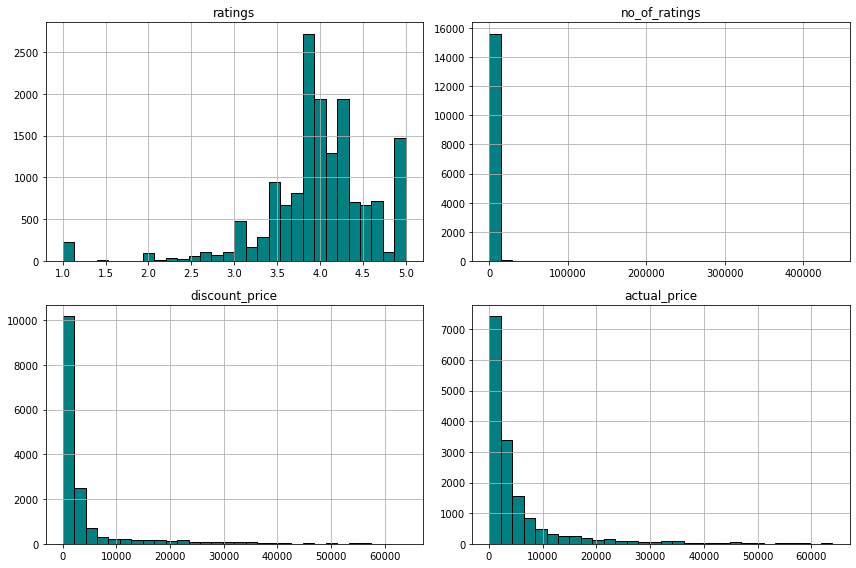

In [46]:
numeric_cols = ['ratings','no_of_ratings','discount_price','actual_price']
frame[numeric_cols].hist(bins=30, figsize=(12,8), color='teal', edgecolor='black')
plt.tight_layout()
plt.show()

In [47]:
# Different main categories present
frame["main_category"].unique()

array(['appliances', 'car & motorbike', 'tv, audio & cameras',
       'sports & fitness', 'grocery & gourmet foods', 'home & kitchen',
       'pet supplies', 'stores', "kids' fashion", 'toys & baby products',
       'bags & luggage', 'accessories', "women's shoes",
       'beauty & health', "men's shoes", "women's clothing",
       'industrial supplies', "men's clothing"], dtype=object)

In [48]:
fig = px.bar(frame, "main_category", 
             color_discrete_sequence = ["#2377a4"] * len(frame))
fig.update_layout(
                 plot_bgcolor = "#ECECEC",
                  yaxis_title = "Count",
                  xaxis_title = "Main Categories",
                  title = "<b>Count of Main Categories of Products</b>"
                 )
fig.show()

In [49]:
import plotly.figure_factory as ff
x = frame["actual_price"]
hist_data = [x]
group_labels = ['actual_price']

fig = ff.create_distplot(hist_data, group_labels, show_rug = False,
                        colors=["#ffd514"])
fig.update_layout(
                 plot_bgcolor = "#ECECEC",
                  title = "<b>Price Distribution of Data</b>"
                 )

fig.show()

In [50]:
import plotly.figure_factory as ff
x = frame["ratings"]
hist_data = [x]
group_labels = ['ratings']

fig = ff.create_distplot(hist_data, group_labels, show_rug = False,
                        colors=["#ffd514"])
fig.update_layout(
                 plot_bgcolor = "#ECECEC",
                  title = "<b>Ratings Distribution of Data</b>"
                 )

fig.show()

In [51]:
fig = px.histogram(frame, "no_of_ratings",
                  color_discrete_sequence = ["#8B4000"] * len(frame))
fig.update_xaxes(range=[10, 5000])
fig.update_yaxes(range=[0, 2000])
fig.update_layout(
                 plot_bgcolor = "#ECECEC",
                  xaxis_title = "Number of Reviews",
                  title = "<b>Number of Reviews Distribution</b>"
                 )
fig.show()

In [52]:
fig = px.scatter(frame, x="actual_price", y="ratings", 
                 trendline="ols")
fig.update_yaxes(range=[0, 5])
fig.update_layout(title = "<b>Relationship between  reviews and actual price</b>",
                 plot_bgcolor = "#ECECEC",
                 yaxis_title = "Number of reviews",
                 xaxis_title = "Discount percent")

fig.show()

c:\Users\pixel\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\pixel\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



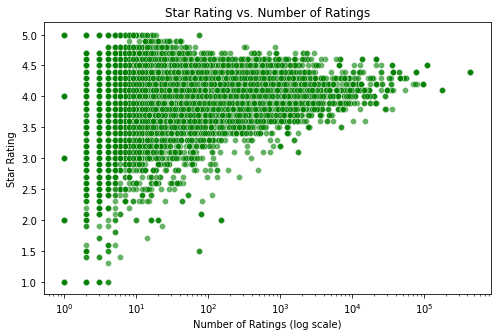

In [53]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x=frame['no_of_ratings'], 
    y=frame['ratings'],
    alpha=0.6, 
    color='green'
)
plt.xscale('log')
plt.xlabel("Number of Ratings (log scale)")
plt.ylabel("Star Rating")
plt.title("Star Rating vs. Number of Ratings")
plt.show()

In [54]:
frame.head()

,name,manufacturer,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price,discount_value,discounting_percent
65,"1 Ton, 5 Star, Wi-Fi Enabled Smart(Alexa/Googl...",Amazon Basics,appliances,Air Conditioners,3.6,88.0,28990.0,49089.0,20099.0,40.944000
83,"1.5 Ton, 5 Star, Wi-Fi Enabled Smart(Alexa/Goo...",Amazon Basics,appliances,Air Conditioners,3.4,39.0,34990.0,56179.0,21189.0,37.716940
112,"1 Ton 4 Star Fixed Speed Window AC (Copper, Tu...",Amazon Basics,appliances,Air Conditioners,3.5,14.0,25490.0,33990.0,8500.0,25.007355
1057,300 W Hand Blender with Stainless Steel Stem f...,Amazon Basics,appliances,All Appliances,4.0,182.0,899.0,1999.0,1100.0,55.027514
1093,"Solimo Laundry Basket with Lid, 55 Litres, Silver",Amazon Brand,appliances,All Appliances,2.6,39.0,829.0,1059.0,230.0,21.718602


c:\Users\pixel\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\pixel\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



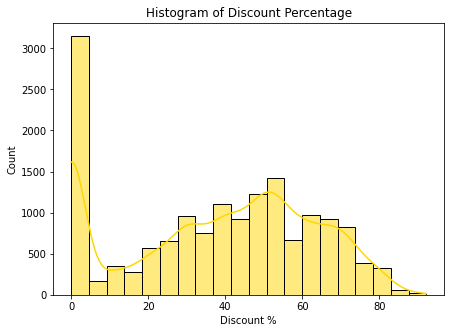

In [55]:
plt.figure(figsize=(7,5))
sns.histplot(frame['discounting_percent'], bins=20, color='gold', kde=True)
plt.title("Histogram of Discount Percentage")
plt.xlabel("Discount %")
plt.show()

In [56]:
print(frame['name'].iloc[0])
print(frame['main_category'].iloc[0])

1 Ton, 5 Star, Wi-Fi Enabled Smart(Alexa/Google Assistant), Single Rotary Inverter Split AC (Copper Condense...
appliances


In [57]:
frame.drop(['main_category','sub_category'], axis=1, inplace=True)

In [58]:
duplicates_count = frame.duplicated().sum()
print("Number of duplicated rows:", duplicates_count)
if duplicates_count > 0:
    frame.drop_duplicates(inplace=True)

Number of duplicated rows: 3148


In [59]:
frame.shape

(12589, 8)

In [60]:
frame.dropna(subset=['name'], inplace=True)

print("Shape after cleaning:", frame.shape)

Shape after cleaning: (12589, 8)


In [61]:
frame['search_terms'] = frame['name'].str.lower()
frame['search_terms'] = frame['search_terms'].str.replace(r'[^\w\d\s]+',' ', regex=True)

In [62]:
stemmer = PorterStemmer()

In [63]:
def stemming_function(sentence):
    """
    Applies stemming on each token in the sentence.
    """
    words = sentence.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    return " ".join(stemmed_words)

frame['search_terms'] = frame['search_terms'].apply(stemming_function)

In [64]:
display(frame[['name','search_terms']].head(3))

,name,search_terms
65,"1 Ton, 5 Star, Wi-Fi Enabled Smart(Alexa/Googl...",1 ton 5 star wi fi enabl smart alexa googl ass...
83,"1.5 Ton, 5 Star, Wi-Fi Enabled Smart(Alexa/Goo...",1 5 ton 5 star wi fi enabl smart alexa googl a...
112,"1 Ton 4 Star Fixed Speed Window AC (Copper, Tu...",1 ton 4 star fix speed window ac copper turbo ...


In [65]:
vectorizer = CountVectorizer(
    max_features=5000,  
    stop_words='english',
    dtype=np.int8
)

feature_matrix = vectorizer.fit_transform(frame['search_terms'])
print("Feature matrix shape:", feature_matrix.shape)

Feature matrix shape: (12589, 5000)


In [66]:
similarities = cosine_similarity(feature_matrix)
print("Similarity matrix shape:", similarities.shape)

Similarity matrix shape: (12589, 12589)


In [67]:
def build_top_neighbors_matrix(sim_matrix, k=10):

    top_neighbors_list = []
    
    for row_idx in range(sim_matrix.shape[0]):
        sim_scores = list(enumerate(sim_matrix[row_idx]))
        sim_scores_sorted = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        top_neighbors = sim_scores_sorted[1:k+1]
        top_neighbors_indices = [item[0] for item in top_neighbors]
        top_neighbors_list.append(top_neighbors_indices)
    
    return np.array(top_neighbors_list, dtype=np.int32)

start_time = time.time()
top_k_neighbors = build_top_neighbors_matrix(similarities, k=10)
end_time = time.time()

print(f"Time to build top-10 neighbors structure: {end_time - start_time:.3f} sec")
print("Shape of top_k_neighbors:", top_k_neighbors.shape)


Time to build top-10 neighbors structure: 51.247 sec
Shape of top_k_neighbors: (12589, 10)


In [68]:
product_names = frame['name'].reset_index(drop=True)
name_to_idx_map = {name: i for i, name in enumerate(product_names)}

In [69]:
def find_index_by_name(product_name):

    return name_to_idx_map.get(product_name, -1)

In [70]:
def get_similar_products(product_query, k=10):
    """
    1) Check the product_query 
    2) Retrieve the product index.
    3) Extract top-k neighbors.
    4) Return recommended items as a DataFrame.
    """
    idx = find_index_by_name(product_query)
    
    if idx == -1:
        print(f"Product '{product_query}' not found in the dataset.")
        return pd.DataFrame()
    
    neighbors_indices = top_k_neighbors[idx][:k]
    
    rec_df = frame.iloc[neighbors_indices].copy()
    rec_df = rec_df[['manufacturer','name','ratings','no_of_ratings','discount_price','actual_price']]
    rec_df.reset_index(drop=True, inplace=True)
    return rec_df

In [71]:
some_product = frame['name'].iloc[8000]
print("::---SELECTED PRODUCT---::")
print(some_product)

print("\n::---TOP 10 RECOMMENDATIONS---::")
recommendations_df = get_similar_products(some_product, k=10)
display(recommendations_df)

::---SELECTED PRODUCT---::
AIR MAX Dawn Mens Shoes

::---TOP 10 RECOMMENDATIONS---::


,manufacturer,name,ratings,no_of_ratings,discount_price,actual_price
0,Nike,Mens Air Max Dawn Running Shoe,4.0,22.0,9295.00,9295.00
1,Nike,Mens Air Max Dawn Running Shoe,4.0,22.0,9177.00,10795.00
2,Nike,Men's Air Max Running Shoes,4.4,32.0,39594.24,39594.24
3,Nike,Men's Air Max LTD 3 Running Shoe,4.4,629.0,27018.90,27018.90
4,Nike,Men's Air Max 1 Essential Shoes 8.5,4.3,175.0,28617.14,28617.14
5,Nike,Air Max Dawn,3.9,9.0,9290.00,9295.00
6,Nike,Mens Air Max Ap Running Shoe,4.4,190.0,6221.00,8295.00
7,Nike,Mens Air Max Impact 3 Sports Shoes,3.6,17.0,11977.80,11977.80
8,Nike,Mens Air Max Sc Running Shoe,4.3,568.0,5990.00,5995.00
9,Nike,Mens Air Max Ap Outdoor Shoes,4.7,57.0,6636.00,8295.00


c:\Users\pixel\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\pixel\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



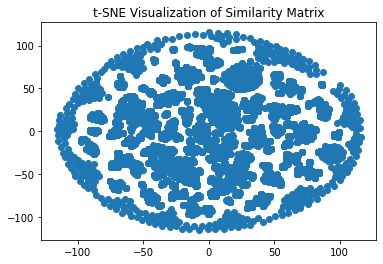

In [72]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensionality for visualization
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(similarities)

# Plot
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
plt.title("t-SNE Visualization of Similarity Matrix")
plt.show()

In [73]:
from sklearn.metrics import silhouette_score

# Example: Assume you have cluster labels (e.g., from K-Means)
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=42)
cluster_labels = kmeans.fit_predict(similarities)

# Calculate silhouette score
silhouette_avg = silhouette_score(similarities, cluster_labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")

Silhouette Score: 0.3580
